# **DOG Rating: Defeating Other Greats**
---

A *Good* player is a player who makes the plays they should make  
A *Great* player is a player who makes the plays they should make, and the ones that they should not be able to make 
A *DOG* is a player who no matter how great the player they are up against is, they are going to make the play

---

## **Introduction**

As a player personnel decision maker in football it is valuable to be able to distinguish good players from great players, as small margins such as these can be the difference between wins and losses on Sundays. What is further valuable is being able to understand how a player will perform against other great players. A player that performs no matter who they are going against is a player that I would deem a **DOG**, a player who **Defeats Other Greats**.

To determine which players are DOGs and thus defeating other great players, it first needs to be determined who the great players are. To do so I have trained a Machine Learning model to predict tackle probability in a tackling event. From here a player's Tackles Over Expected (`TOE`) is calculated for defensive players, and Broken Tackles Over Expected (`BTOE`) for offensive players. A player's `TOE` or `BTOE` is then weighted based upon the amount of tackling events the player was involved to diminish bias towards players who performed well in the few tackling scenarios they faced. This left each player with a Weighted Tackles Over Expected (`Weighted_TOE`) or Weighted Broken Tackles Over Expected (`Weighted_BTOE`) dending if they are an defensive or offensive player respectively. A player's DOG Rating, which can be calculated and used to evaluate both offensive and defensive players, is then calculated based upon the sum of the `Weighted_TOE` or `Weighted_BTOE` of the players they faced in tackling events. Providing a metric that takes into account the quality of player a player is going up against and can help increase understanding of how both offensive and defensive players perform against other great players in tackling situations. The players with the highest positive DOG ratings routinely defeat other great players.

---

## **Dataset**

Football is a complex and beautiful game, and tackling events are not an exception to this chaos. Whether its a gang tackle, a blocker impeding the path of a defender to the ball carrier, or the undefeated defender; the sideline, many different factors play a role in tackling events. To try and isolate these events while still maintaining a robust enough dataset for modeling, all tackling events where a player was only credited with an assist were removed. Thus, leaving only observations where a tackler's role in the tackling event was significant enough for them to be credited with a solo tackle, or events where they were credited with a missed tackle according to Pro Football Focus' (PFF) `pff_missedTackle` metric. (Observations where there were both a solo tackle and assist credited on the same player were not removed due to trying to allow the metric to take into account some of the complexity of the game of football as well as to maximize the size of the dataset for modeling. That being said, if it was desired for tackling events to be more stringent and only consider plays where there was just a solo tackle and no assist, these observations have been saved and can be easily removed and the analysis re-run.)

From here niche scenarios were considered such as splitting observations into two in which a player both missed and made a tackles on the same play, removing observations where a defender wad credited with a tackle for forcing a ball carrier out of bounds, and consider observations as made tackles when a defender forced a fumble but did not actually tackle the ball carrier. After cleaning the final dataset included **9720** observations or *tackling events*, with **7834** being *Made Tackles* and **1886** being *Misssed Tackles*, a **80.6%** to **19.4%** split respectively. 

---

## **Feature Set**

For the dataset, the 6 features were generated for each observation. These features are the:
- **Speed of the Defender (s)**
- **Speed of the Ball Carrier (bc_s)**
- **Cosine Similarity between the Defender and Ball Carrier (cos)**
- **Body Alignment of the Defender (do)**
- **Body Alignment of the Ball Carrier (bc_do)**
- **Indicator for the Cosine Similarity not being calculable**

 To try to capture some of the nuance in the influence of what happens before a tackle event has on the outcome, each of these features was averaged for the half second before the tackling event (not including the event so frames *event - 1* through *event - 5*), and then the half second after that (frames *event - 6* through *event - 10*). These averages will be denote by **'05'** and **'1'** following the variable name respectively. This left the final feature set at 12 features: 
 - `s_avg_05`
 - `s_avg_1`
 - `bc_s_avg_05`
 - `bc_s_avg_1`
 - `cos_avg_05`
 - `cos_avg_1`
 - `do_avg_05`
 - `do_avg_1`
 - `bc_do_avg_05`
 - `bc_do_avg_1`
 - `cos_05_null`
 - `cos_1_null`

 The features that required further calculation beyond being provided will now be discussed in more detail.


#### **Cosine Similarity**

Cosine Similarity measures the alignment of the angle between two vectors. In this case the two vectors are the Defender and Ball Carrier in a tackling event. In the Cosine Similarity formula, the terms represent the following:

- $\mathbf{A}$: Represents the vector for the Defender in a tackling event.
- $\mathbf{B}$: Represents the vector for the Ball Carrier in a tackling event.
- $\mathbf{A} \cdot \mathbf{B}$: Represents the Dot Product of the two vectors.
- $\|\mathbf{A}\|$: Is the norm (or length) of vector $\mathbf{A}$, which gives the magnitude of the Defender's movement.
- $\|\mathbf{B}\|$: Is the norm (or length) of vector $\mathbf{B}$, which gives the magnitude of the Ball Carrier's movement.

$$\cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$$


In a case where the Defender or Ball Carrier does not during the entire half second before a tackling event, or during the entire half second prior to that, Cosine Similarity will be undefined as $\|\mathbf{A}\|$ or $\|\mathbf{B}\|$ would be equal to 0, thus making the denominator 0. For this reason the indicator variables of `cos_05_null` and `cos_1_null` are included to account for these scenarios, and the `cos_avg_05` or `cos_avg_1` is imputed with a value of **0**, depending on which is/are undefined.

The Cosine Similarity between two vectors range continusouly from -1 to 1.
- 1: Meaning the Defender and Ball Carrier are heading in the same direction (0&deg; difference)
    - An example would be a Defender hawking a Ball Carrier
- 0: Meaning the Defender and Ball Carrier are heading directions 90&deg; apart from each other 
    - An example would be a Ball Carrier running down field and a Defender shedding a block and diving sideways to make the tackle
- -1: Meaning the Defender and Ball Carrier are heading in opposite directions (180&deg; difference)
    - An example would be a Defender and Ball Carrier heading towards a head on collision

### **Body Alignment**

Body Alignment seeks to encapsulate the relationship between a player's direction `dir` and orientation `o`. A player's direction is there direction in which they are moving in. Whereas their orientation is the direction they are facing. In most cases for making a tackle it qualitatively seem reasonable that it is advantageous for a Defender to be facing the same direction they are facing and thus having an *aligned* body positioning when going into a tackling event. 

The alignment between the direction of the player ($dir$) and the orientation of the Ball Carrier ($o$) is calculated as follows:

$$
do\_align = -\left| \left( \left( dir - o + 180 \right) \mod 360 \right) - 180 \right| / 90 + 1
$$

In this formula:
- $dir - o$ calculates the difference between the direction and orientation of the player

- Adding 180 and taking modulo 360 ensures the result is in the range from 0 to 360

- Subtracting 180 and taking the absolute value ensures the result is in the range from 0 to 180

- Dividing by 90 and adding 1 normalizes the result to a range from -1 to 1 to provide the same scale as Cosine Similarity

The Body Alignment of a player ranges continuously from -1 to 1.
- 1 Meaning the player is facing the exact same direction they are moving (0&deg; difference)

- 0 Meaning the player is facaing 90&deg; from the direction they are moving

- -1 Meaning the player is facing the opposite direction from where they are moving (180&deg; difference)
    - An example would be a player who is back pedaling

For Defenders their direction-orientation alignment was saved as `do` and for Ball Carriers it was saved as `bc_do`. 

---

## **Modeling**

As previously stated, the goal of modeling in this project was to create a Tackle Probability model with the goal of calculating a Defender's `Weighted_TOE` and a Ball Carrier's `Weighted_BTOE`. 

### **Train - Validation - Test Split**

Prior to modeliong, the dataset was split into a 60-10-30 Train-Validation-Test split. Each split was made up of the following number of observations:
- Train: 5856 observations
    - 81.05% Made Tackles
    - 18.95% Missed Tackles
- Validation: 947 observations
    - 77.93% Made Tackles
    - 22.07% Missed Tackles
- Test: 2917 observations
    - 80.56% Made Tackles
    - 19.44% Missed Tackles
- Entire Dataset: 9720 observations
    - 80.60% Made Tackles
    - 19.40% Missed Tackles
    
The split took into account the defender from each observation and split there observations evenly across the three splits. For players who had very few observations, some ended up with no data in the *Test* split, ultimately resulting in them being assigned a `Weighted_TOE` or `Weighted_BTOE` of **0**. 

In the scenario of having multiple years data I would have trained the models on previous data and made sure that no player (group) was split across the different data splits. I would have then conducted **Multi-level Cross Validation**** in the training of my models. Due to only having 9 weeks of data, and needing to have holdout test results on players who were also in the training data for metric development, I opted to split each player's data across the three splits. Due to none of the features being biographical and strictly situational, there is less of an issue with the model becoming familiar with certain players and thus facing a data leakage issue with having the same players represented in the training and test sets. That being said, there is still a possibility of this and that should be considered under the limitations of the current approach.

Due to not having the each player's observations strictly assigned to one split, I opted to conduct **Nested Cross Validation** for hyperparamter selection and training.

### **Model Training and Testing**

To train models **scikit learn's** `sklearn` package was used. The first model trained was a **Logistic Regression**. If a more interpetable model is preferred, this model is saved and the analysis can easily be re-conducted using the Logistic Regression. The second model trained was a **Random Forest Classifier**, a tree-based model, which was ultimately chosen for analysis due to its overall better performance in recognizing both the positive and negative class. As the metric was originally intended to be defense focused, the classees are as follows:
- 1: Made Tackle (Positive Class)
- 0: Missed or Broken Tackle (Negative Class)

#### **Nested Cross Validation**

As Nested Cross Validation inherently validates on unseen data, the Validation set was now a floating 10% that I could either add to the Train set or Test set depending on if I thought it would be more valuable to have in training or metric creation. After training the models on the 60% Train set and hoping more training data might improve model performance, I decided to combine the Validation set with the Train set leaving new 70% Train_Validation set which had the following breakdown: 
- Train_Validation: 6803 observations
    - 80.61% Made Tackles
    - 80.39% Missed Tackles

For my nested Cross Validation I used **5** folds in both my outer and inner cross validation


#### **Logistic Regression**

The Hyperparamters used to train the final Logistic Regression model are as follows:
- `C`: 0.3593813663804626
- `solver`: saga
- `penalty`: l2
- `max_iter`: 250
- `class_weight`: None

The Feature Importances of the Logistic Regression are as follows: 

![Logistic Regression: Feature Importance](Figures/LR_FI.png)




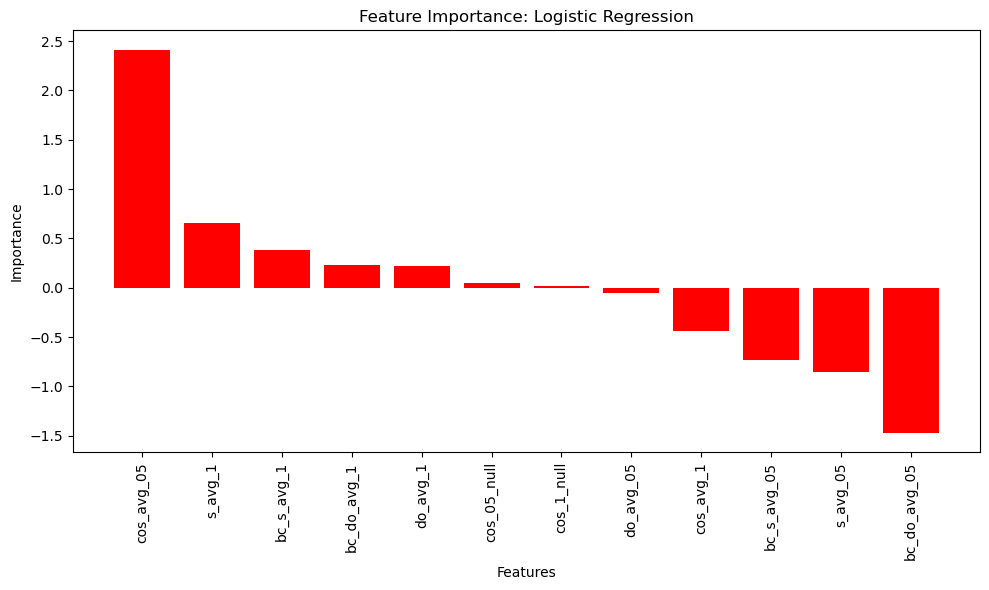

In [3]:
import IPython
from IPython.display import Image
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/LR_FI.png')

The performance of the Logistic Regression on the holdout test set is as follows:

- Precision: 0.9090173877881116
- Recall: 0.9565957446808511
- F1 Score: 0.9321998755961021
- Precision_0: 0.7702702702702703
- Recall_0: 0.6031746031746031
- F1_0 Score: 0.6765578635014837
- Accuracy: 0.8878985258827563

Confusion Matrix:
| Confusion Matrix | Predicted: Missed/Broken Tackle | Predicted: Made Tackle |
|------------------|---------------|----------------|
| Actual: Missed/Broken Tackle       | 342 | 225 |
| Actual: Made Tackle      | 102 | 2248 |

It can be seen that the Logistic Regression model performs quite well in clasifying Made Tackles, but struggles more in the scenario of Missed/Broken tackles.

#### **Random Forest Classifier**

The Hyperparameters used to train the final Random Forest Classifier model are as follows:
- `max_depth`: 10
- `min_samples_leaf`: 5
- `min_samples_split`: 5
- `n_estimators`: 225
- `random_state`: 42

The Feature Importances of the Random Forest Classifier are as follows:




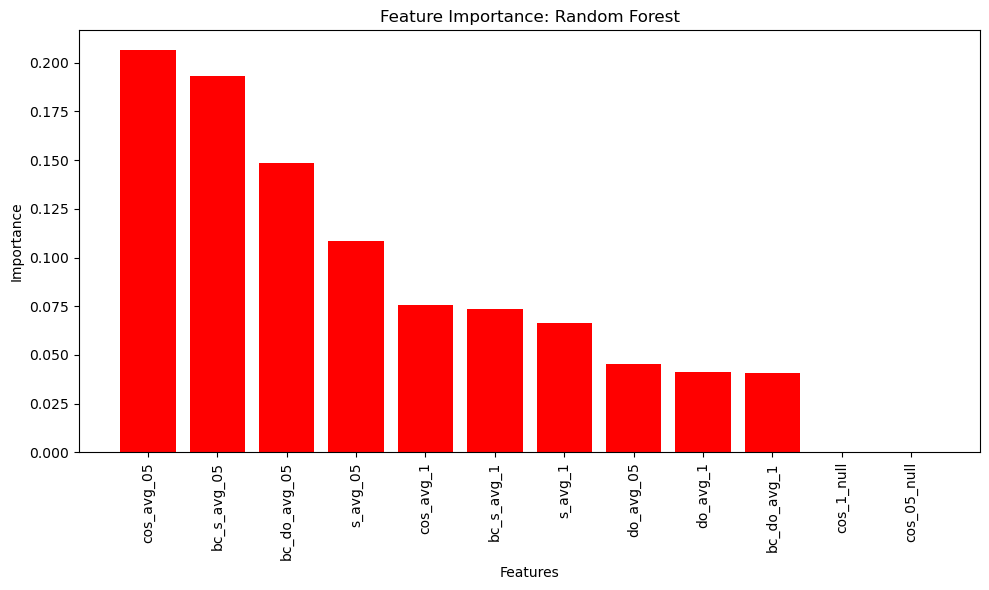

In [4]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/RFC_FI.png')



The performance of the Random Forest Classifier on the holdout test set is as follows:

- Precision: 0.9184091840918409
- Recall: 0.9531914893617022
- F1 Score: 0.9354771351012737
- Precision_0: 0.7698744769874477
- Recall_0: 0.6490299823633157
- F1_0 Score: 0.7043062200956938
- Accuracy: 0.8940692492286596

Confusion Matrix:
| Confusion Matrix | Predicted: Missed/Broken Tackle | Predicted: Made Tackle |
|------------------|---------------|----------------|
| Actual: Missed/Broken Tackle       | 368 | 199 |
| Actual: Made Tackle      | 110 | 2240 |






While the Random Forest Classifier performs slightly worse than the Logistic Regression in classifying Made Tackles properly, it does better in classifying Missed/Broken Tackles, making it more balanced than the Logistic Regression in classifying both classes. This is important as the ability to classify both classes influences a player's `Weighted_TOE` or `'Weighted_BTOE`, thus it is important for the model to perform as well as possible in identifying both classes correctly. The Random Forest Classifier model also had an accuracy of **89.4%**, a slight increase over the Logistic Regression model's accuracy of **88.8%**. For these reasons, the decision was, made to use the Random Forest Classifier for metric development.

---

## **Developing Tackles Over Expected and Broken Tackles Over Expected Metrics**

To develop each individual player's Tackles Over Expected(`TOE`) or Broken Tackles Over Expected(`BTOE`) their tackling events in the test set were ran through the Random Forest Classifier model to produce a confusion matrix for each individual player. These confusion matrices provide the following information:

For Defensive Players:

| Confusion Matrix | Predicted: Missed Tackle | Predicted: Made Tackle|
|------------------|---------------|----------------|
| Actual: Missed Tackle      | Tackles that were missed (TN) | Tackles that should not have been missed but were (FP) |
| Actual: Made Tackle      | Tackles that should not have been made but were (FN) | Tackles that were made (TP) |

For Offensive Players:

| Confusion Matrix | Predicted: Broken Tackle | Predicted: Made Tackle |
|------------------|---------------|----------------|
| Actual: Broken Tackle      | Tackles that were broken (TN) | Tackles that should not have been broken but were (FP) |
| Actual: Made Tackle    | Tackles that should have been broken but were not (FN) | Tackles that were made (TP) |

From here, the calculation of `TOE` or `BTOE` is straightforward:
For a Defender, their `TOE` is:

$$FN-FP$$

This is: **The number of tackles they should not have been able to make but did ($FN$) - The number of tackles that they should not have missed but did ($FP$)**


For a Offensive Player, their BTOE is the inverse due to "positive" outcome for Offensive Players being the class represnted by 0: Missed/Broken Tackles. Therefore there `BTOE` is:

$$FP-FN$$

This is: **The number of tackles they should not have been able to break but did ($FP$) - The number of tackles they should have been able to break but did not ($FN$)**


Both `TOE` and `BTOE` were then weighted to account for bias towards players who found success when only faced with a few tackling events. The weighting formula was:

$$Weight = \frac{num\_tackling\_events}{max\_tackling\_events}$$


Therefore the player with the most tackling events on their respective side of the ball would have their `TOE` or `BTOE` multiplied by **1**, whereas a player who was involved in half as many tackling events would have their `TOE` or `BTOE` multiplied by **0.5**. The final formula for the `Weighted_TOE` which applies to defenders was: 

$$Weighted\_TOE = (FN - FP) \times Weight$$
The final formula for `Weighted_BTOE` which applies to ball carriers was:

$$Weighted\_BTOE = (FP - FN) \times Weight$$


Now that each player had their `Weighted_TOE`, or `Weighted_BTOE` calculated, the measure of how "great" of a player they are and a valuable metric in itself, each players `DOG Rating` can now be calculated.

## **DOG Ratings**

As stated earlier, a *DOG* is a player who no matter how great the player they are up against is, they are going to make the play. Therefore, a player's `DOG Rating` is a metric that sums up their performance against great players, or, their ability to **D**efeat **O**ther **G**reats. The formula for a player's `DOG Rating` is as follows:

Defense:


SUM(If Made Tackle: $\max(\text{Weighted\_BTOE}, 0)$, If Missed Tackle: $\min(\text{Weighted\_BTOE}, 0)$)

Offense:

SUM(If Tackled: $\min(\text{Weighted\_TOE}, 0)$, If Broken Tackle: $\max(\text{Weighted\_TOE}, 0)$)




The formula makes it so Defenders have their `DOG Rating` increase when they make plays on Ball Carriers with positive `Weighted_BTOE`, and decrease when they miss plays on Ball Carriers with negative `Weighted_BTOE`. For Ball Carriers, their `DOG Rating` increases when they break tackles against Defenders with positive `Weighted_TOE`, and decreases when they get tackled by players with negative `Weighted_TOE`. The result is a metric that for both Offensive and Defensive players provides a metric for performance when facing other great players in tackling scenarios.

### **Results**

#### **Defense**

The following are results for Defensive players in terms of DOG Rating both overall, and broken down by some positions

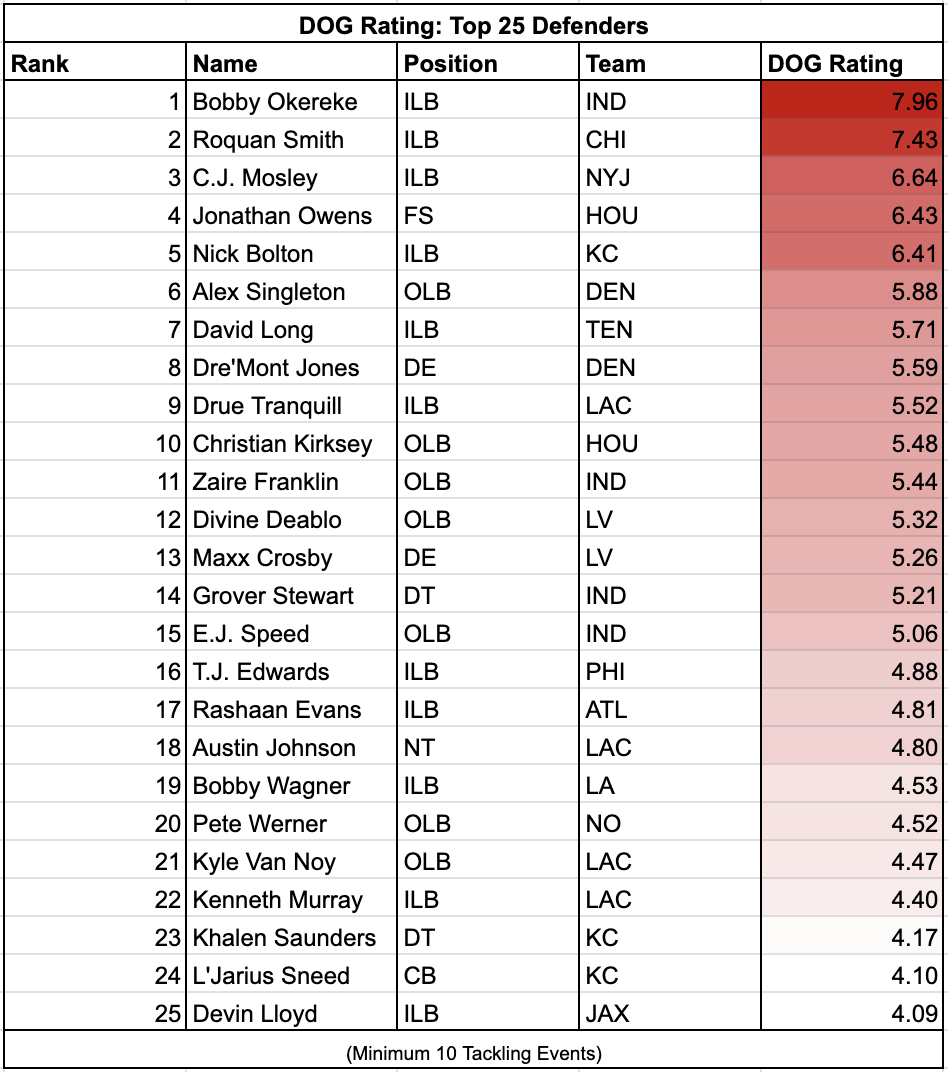

In [6]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/Top_25_D.png')

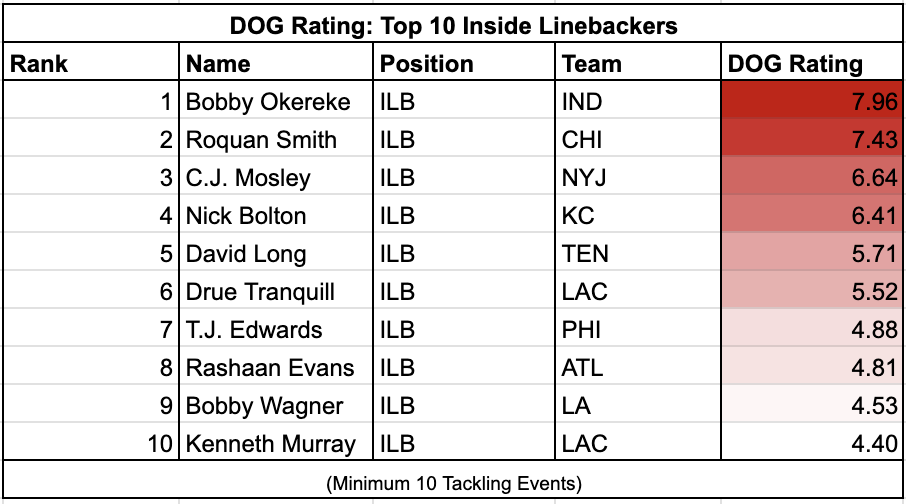

In [7]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/Top_10_ILBs.png')

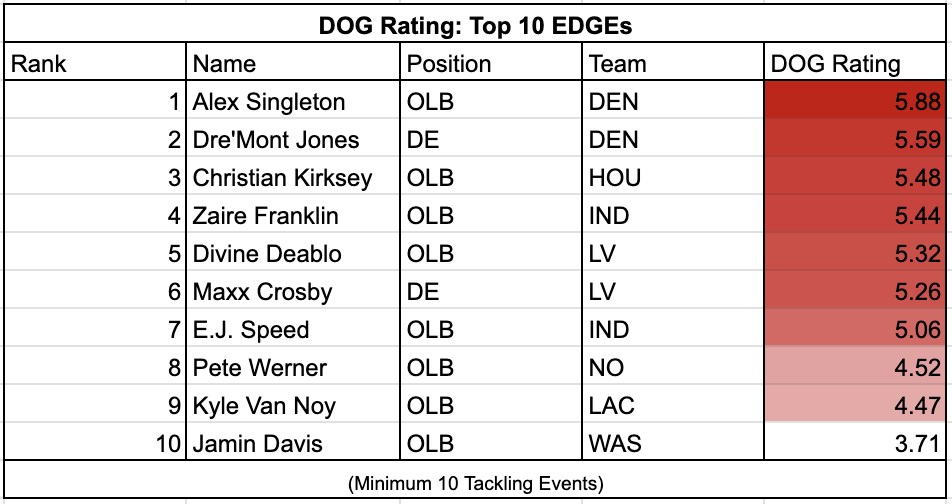

In [8]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/TOP_10_Edges.png')

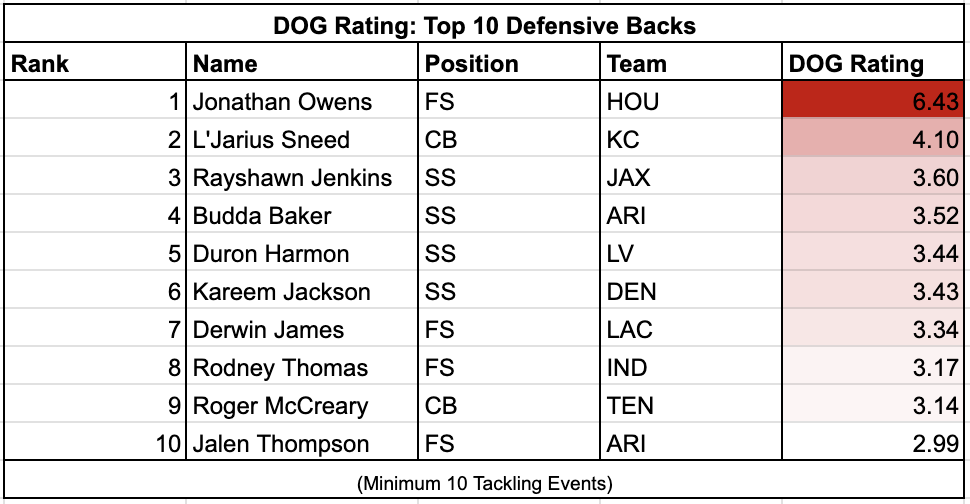

In [9]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/TOP_10_DBs.png')

#### **Offense**

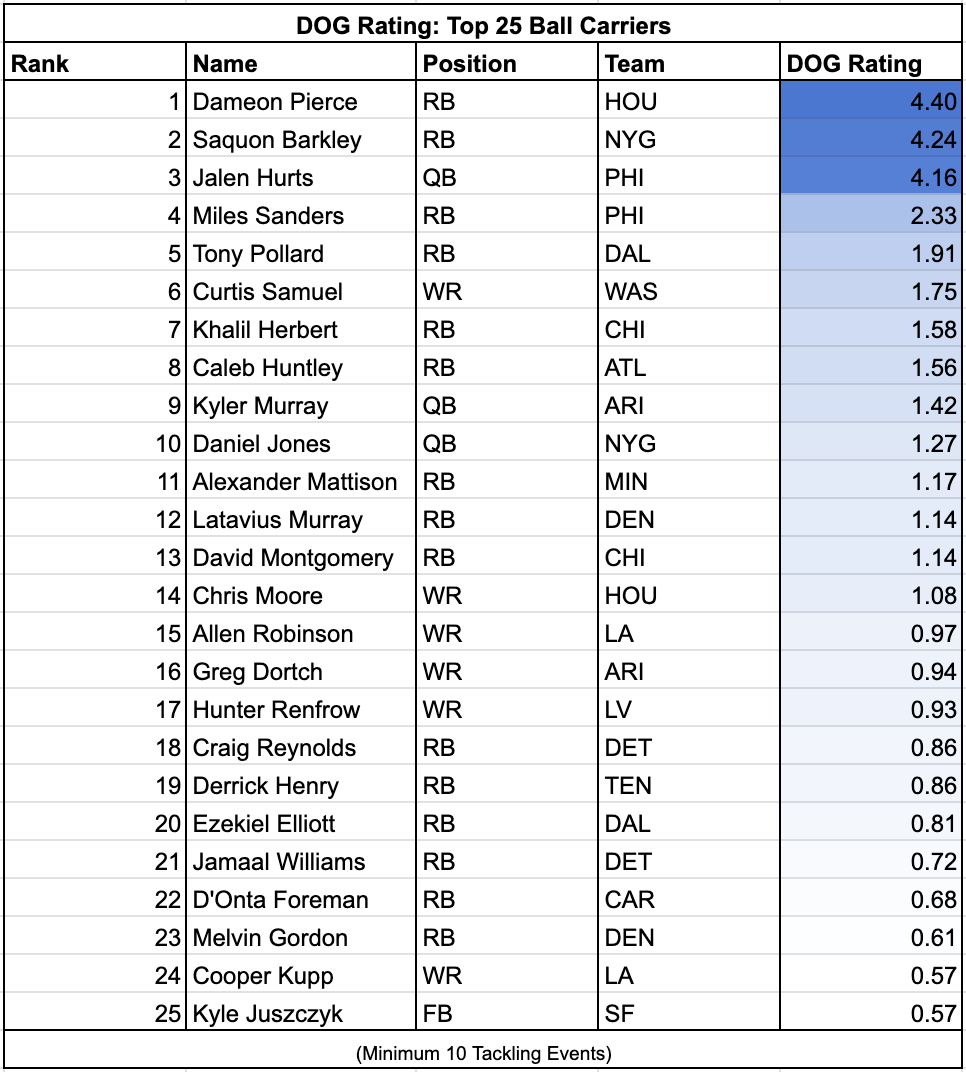

In [10]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/Top_25_O.png')

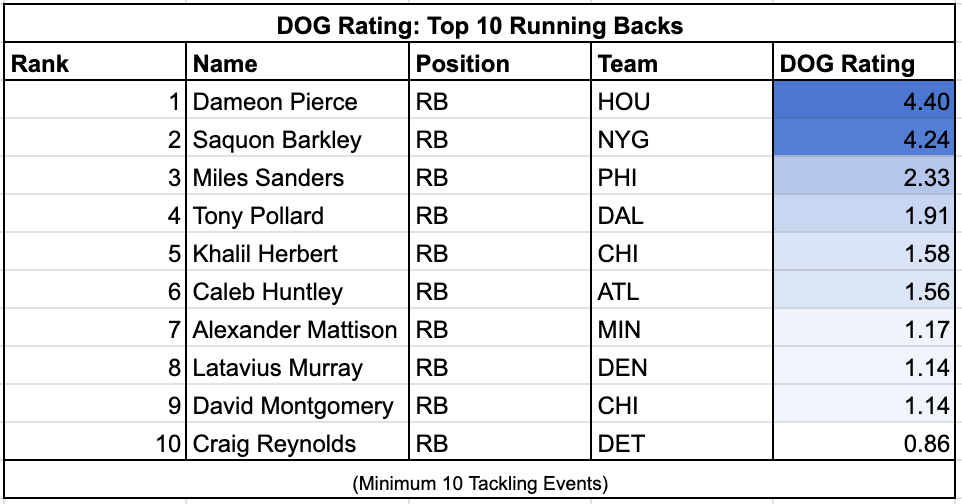

In [11]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/TOP_10_RBs.png')

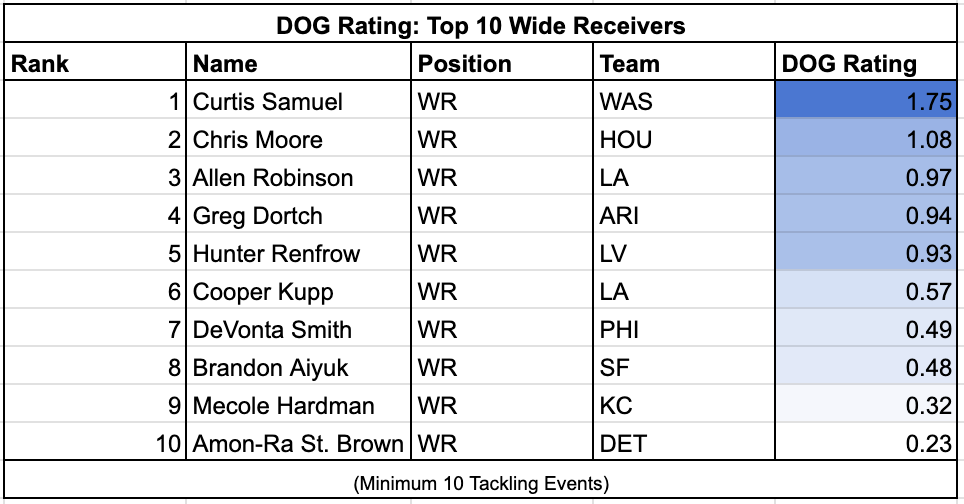

In [12]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/TOP_10_WRs.png')

#### **Weekly:**

A player's `DOG Ranking` can also be evaluated on a week-to-week basis. Here is an example from *Bobby Okereke*, the defender with the highest `DOG Rating` through the first 9 weeks of the 2022 NFL season.

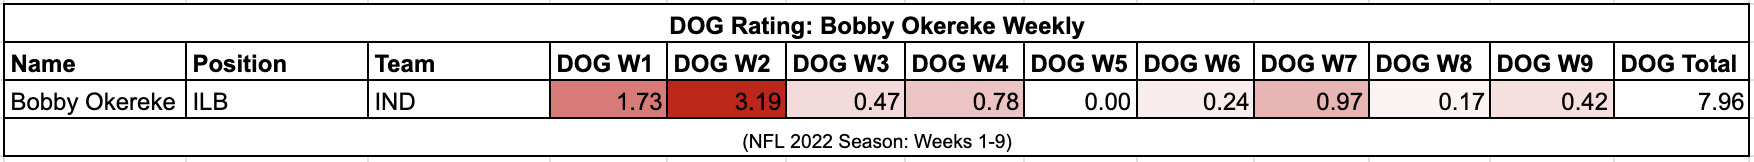

In [13]:
Image(filename='/Users/alexiainman/Documents/Big Data Bowl/Figures/DOG_Weekly.png')

## **Conclusion**

A player's `DOG_Rating` is a metric that allows player personnel decision makers to understand how both Offensive and Defensive players perform against other great competition. If a team wants **DOGs** on their roster, they should consider starting to use `DOG_Rating`

## **Code**

https://github.com/labounty/DOGRatingNFLBDB24 

Trey LaBounty | Stanford University